### Import des libraires
- Pandas : gestion heterogène array
- Numpy : gestion homogène array
- Torch : ML/DL pour création de nn, transformation audio
- Matplotlib : Pour plot des données
- Tqdm : bar de chargement entrainement

In [136]:
import csv
import os
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio.transforms as T

from tqdm import tqdm



On définit le device sur mps étant sur un silicon pour faire de la parralélisation

In [137]:
device = torch.device("mps")

### Dataset
Contexte de la donnée:
On a 3 datasets utilisable : test, train, validated. J'ai donc décidé de les concaténer pour finalement avoir un dataset beaucoup plus grand comme ça on facilite la segmentation de la donnée : 80/20%

- Récupération de la donnée dans les fichier tsv
- Cleanning de la data (Valeurs null ou à 0)
- Filtre données : on ne garde que les target = 1, 2, 3 ou 4

In [138]:
# train_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/train.tsv',sep='\t')
# train_data[['path', 'sentence']] = train_data[['path', 'sentence']].replace('', np.nan)
# train_data_numbers = train_data

# test_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/test2.tsv',sep='\t')
# test_data[['path', 'sentence']] = test_data[['path', 'sentence']].replace('', np.nan)
# test_data_numbers = test_data

validate_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/validated.tsv',sep='\t')
validate_data[['path', 'sentence']] = validate_data[['path', 'sentence']].replace('', np.nan)
validate_data_numbers = validate_data[validate_data['sentence']!='sept']

# train_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
# test_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
validate_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)

# print(f"train rows: {train_data_numbers.shape[0]}")
# print(f"test rows: {test_data_numbers.shape[0]}")
print(f"validate rows: {validate_data_numbers.shape[0]}")



validate rows: 18564


/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_16056/1216890802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)


In [139]:
validate_data_numbers.head(5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,02ccda0cd258d89228fc66cb072eb9bafbb1ae9f39dc8b...,common_voice_fr_23890678.mp3,huit,2,0,NaN,NaN,NaN,fr,Benchmark
1,05a87054181791477a299a08fc35a6ff0c53250cae313e...,common_voice_fr_22108074.mp3,zéro,2,0,NaN,NaN,NaN,fr,Benchmark
2,06c9c9e703dfa759edf4836936b42a07afd1021cedb06c...,common_voice_fr_22098482.mp3,trois,2,0,NaN,NaN,NaN,fr,Benchmark
3,07a7db773acd156dd0b7fdc32f6b5eda9b32ffa1b3aee7...,common_voice_fr_21955578.mp3,quatre,6,3,NaN,NaN,NaN,fr,Benchmark
4,0eb85c7dcb9b7ca2caec05a0dbbf6ee983cfab19164dac...,common_voice_fr_22157149.mp3,Firefox,3,1,NaN,NaN,NaN,fr,Benchmark


In [140]:

print(validate_data_numbers['sentence'].value_counts())

sentence
deux       1492
zéro       1471
trois      1453
quatre     1445
cinq       1445
oui        1440
non        1439
six        1430
neuf       1428
Hey        1397
un         1383
huit       1376
Firefox    1365
Name: count, dtype: int64


### Fonction pour load les mp3
```python3  
def Load_waveform() 
```
Convertit un mp3 en waveform (manipulable en code)

-----------------------------------------------------------------------------

```python3  
def Load_waveformes() 
```
Itère dans les 3 datasets et convertit tous les fichiers

In [141]:
def load_waveform(mp3_file):
    waveform, sample_rate = torchaudio.load(mp3_file, format='mp3')
    return waveform, sample_rate

def load_waveformes(df,waveformes,targets):
    for mp3_path in df['path']:
        waveform, _ = load_waveform(f'data/cv-corpus-7.0-singleword/fr/clips/{mp3_path}')
        waveformes.append(waveform)
        targets.append(df[df['path'] == mp3_path]['sentence'].values[0])


### Création des array contenant toutes nos données 
On pourra transformer ces array en TorchDataset plus tard ce qui va faciliter la compréhension

In [142]:
waveformes = []
targets = []

# load_waveformes(train_data_numbers,waveformes,targets)
# load_waveformes(test_data_numbers,waveformes,targets)
load_waveformes(validate_data_numbers,waveformes,targets)

print(f"waveformes: {len(waveformes)}")
print(f"targets: {len(targets)}")

### Petit check si les données sont bien équilibré 
Si le nombre de données est différent d'une classe à l'autre alors notre modèle sera biaisé 

([<matplotlib.axis.XTick at 0x6813e4210>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14')])

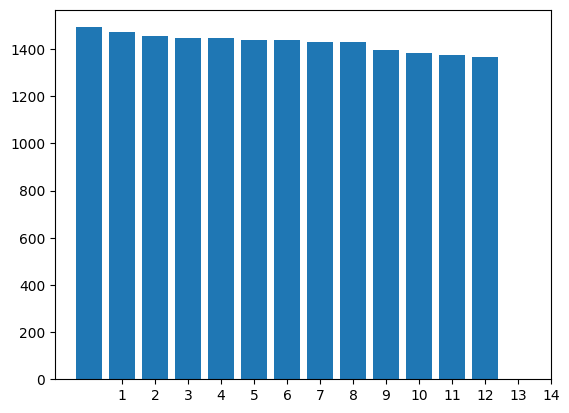

In [ ]:
count=pd.Series(targets).value_counts()
plt.bar(count.index,count.values)
plt.xscale('linear')
plt.xticks(range(1,15,1))

### String -> Numeric
On va map nos données target pour faciliter l'entrainement de notre modèle
Celui-ci va prédir une donnée numérique en output et on calculera la loss par rapport à la value de la classe correspondante

In [ ]:
map = {
    'un': 1,
    'deux': 2,
    'trois': 3,
    'quatre': 4
}

targets = [map[i] for i in targets]

### Transformation de nos waveform en spectrogram

In [ ]:
transform = MelSpectrogram(sample_rate=48000, n_mels=40, n_fft=512, hop_length=256)
spectrograms = [transform(wave).squeeze(0) for wave in waveformes]

### Normalisation des données (Pour un CNN 25% -> 75% avec une normalisation standard)

In [ ]:
def normalize_spectrograms(spectrograms):
    normalized_spectrograms = []
    for s in spectrograms:
        mean = s.mean()
        std = s.std()
        normalized_spectrograms.append((s - mean) / std)
    return normalized_spectrograms

spectrograms = normalize_spectrograms(spectrograms)

In [ ]:
print(spectrograms[1].shape)

torch.Size([40, 977])


In [ ]:
print(spectrograms[0].shape)
print(spectrograms[0].shape[1])

torch.Size([40, 374])
374


In [ ]:
max = 0
for mel in spectrograms:
    if mel.shape[1] > max:
        max = mel.shape[1]
print(max)

2296


### On transpose notre tensor pour avoir les time frame en première dimension 

In [ ]:
spectrograms = [mel.transpose(0, 1) for mel in spectrograms]
print(spectrograms[0].shape)

torch.Size([374, 40])


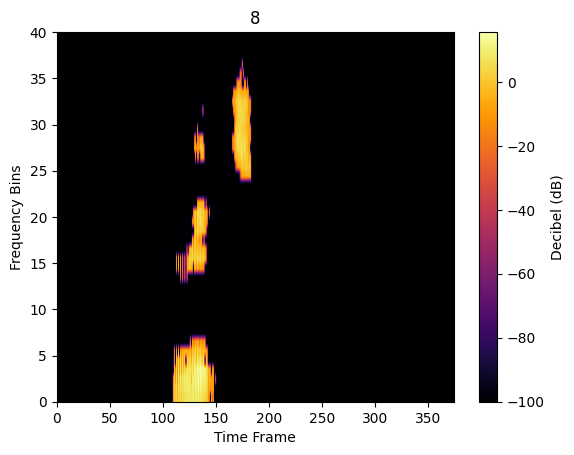

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='Frequency Bins', aspect='auto', xmax=None):
    """
    Plots a spectrogram with the time axis on the x-axis and frequency bins on the y-axis.
    
    Parameters:
        spec (np.ndarray or torch.Tensor): The spectrogram tensor/array.
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label for the y-axis.
        aspect (str, optional): Aspect ratio of the plot. 'auto' fills the axes with the data.
        xmax (int, optional): Maximum value for the x-axis (time axis).
    """
    # Transform amplitude spectrogram to decibel scale
    spec_to_db = T.AmplitudeToDB(stype='power')
    spec_db = spec_to_db(spec)

    # Check if the input is a tensor and convert to numpy for plotting
    if isinstance(spec_db, torch.Tensor):
        spec_db = spec_db.numpy()

    # Transpose the spectrogram to align time on the x-axis and frequency bins on the y-axis
    spec_db = spec_db.T  # now the shape should be [time, frequency]

    # Create the plot
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('Time Frame')
    
    # Adjust the extent to properly scale the axes, with time on the x-axis and frequency on the y-axis
    cax = axs.imshow(spec_db, aspect=aspect, origin='lower',
                     extent=[0, spec_db.shape[1], 0, spec_db.shape[0]],
                     cmap='inferno')
    
    # Set maximum x-axis value if provided
    if xmax:
        axs.set_xlim([0, xmax])
    
    # Add a colorbar to the plot to indicate the decibel scale
    fig.colorbar(cax, label='Decibel (dB)')
    plt.show()

plot_spectrogram(spectrograms[0].squeeze(0), title=targets[0])

### Padding 
Pour avoir des séquence de même données 

In [ ]:
def pad(spectrograms, max_size):
    padded_spectrograms = []
    for mel in spectrograms:
        current_size = mel.shape[0]
        if current_size < max_size:
            total_pad = max_size - current_size
            pad_top = total_pad // 2
            pad_bottom = total_pad - pad_top
            padded_mel = F.pad(mel, (0, 0, pad_top, pad_bottom))
        else:
            padded_mel = mel
        padded_spectrograms.append(padded_mel)
    return padded_spectrograms

padded_spectrograms = pad(spectrograms,max)

### Création d'audio null

#### Ajout aux au listes servant de dataset 

### Séparation 80/20

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_spectrograms, targets, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_test))

14851
3713


In [ ]:
# Stack permet de transformer une liste de tensor en un seul tensor
X_train_tensor = torch.stack(X_train)
X_test_tensor = torch.stack(X_test)  

y_train_tensor = torch.tensor(y_train).long() 
y_test_tensor = torch.tensor(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
print(len(train_dataset))
print(len(test_dataset))

14851
3713


In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
acc = []
def train_lstm(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for spectrograms, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                outputs = model(spectrograms)  
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Average loss for this epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed: Avg. Loss: {average_loss:.4f}")
        acc.append(average_loss)

In [ ]:
def test_lstm(model, test_loader):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)
            acc_total += (predicted==labels).sum().item()/len(labels)
        print(f"Accuracy: {acc_total/len(test_loader)}")

In [ ]:
train_mask = (y_train_tensor == 1) | (y_train_tensor == 2)
test_mask = (y_test_tensor == 1) | (y_test_tensor == 2)

X_train_filtered = X_train_tensor[train_mask]
y_train_filtered = y_train_tensor[train_mask]
X_test_filtered = X_test_tensor[test_mask]
y_test_filtered = y_test_tensor[test_mask]

train_dataset = TensorDataset(X_train_filtered, y_train_filtered)
test_dataset = TensorDataset(X_test_filtered, y_test_filtered)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
num_layers = 4
hidden_size = 50
# Input_size = n filter
input_size = train_dataset[0][0].shape[1]
# Séquence length = padding = 2296
sequence_length = train_dataset[0][0].shape[0]
num_classes = 4
dropout = 0.2
lr = 0.001
num_epochs = 5

lstm = LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout)
# lstm = torch.load('new-lstm-15epch-15clas-88acc.pth')
lstm.load_state_dict(torch.load('new-lstm-15epch-15clas-88acc-weights.pth'))
lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr)
train_lstm(lstm, train_loader, optimizer, criterion, epochs=num_epochs)


RuntimeError: Error(s) in loading state_dict for LSTM:
	size mismatch for fc.weight: copying a param with shape torch.Size([13, 114800]) from checkpoint, the shape in current model is torch.Size([15, 114800]).
	size mismatch for fc.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([15]).

In [ ]:
test_lstm(lstm, test_loader)

Accuracy: 0.98046875


In [ ]:
torch.save(lstm, 'new-lstm-13clas-88acc.pth')

Nouvelle fonction de score :
- On ne doit avoir que 5 classes qui vont changer la logique du jeu :
    - un/deux/trois/quatre
    - autre 

Si on reconnait un chiffre alors on aura soit une réponse bonne ou une réponse mauvaise 
Par contre, si on ne reconnait pas un chiffre alors on aura juste (pas de réponse donnée ou réponse non reconnu)
On va donc agréger beaucoup de classe entre elle et le but sera de tester par rapport à ces 5 classes

```map = {
    'un': 1,
    'deux': 2,
    'trois': 3,
    'quatre': 4,
    'cinq': 5,
    'six': 6,
    'sept': 7,
    'huit': 8,
    'neuf': 9,
    'oui': 10,
    'non': 11,
    'Firefox': 12,
    'Hey': 13,
    'zéro': 14,
    'null': 15,
}
```



In [ ]:
new_map = {
    1: 1,  
    2: 2,  
    3: 3,  
    4: 4,  
    5: 5,  
    6: 5,
    7: 5,
    8: 5,
    9: 5,
    10: 5,
    11: 5,
    12: 5,
    13: 5,
    14: 5,
}

def remap_labels(labels, new_map):
    return torch.tensor([new_map[label.item()] for label in labels], dtype=torch.long)

def new_test_lstm(model, test_loader, new_map):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            remapped_labels = remap_labels(labels, new_map)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)

            remapped_predicted = remap_labels(predicted, new_map)
            acc_total += (remapped_predicted == remapped_labels).sum().item() / len(labels)
        
        print(f"Accuracy: {acc_total / len(test_loader)}")

In [ ]:
new_test_lstm(lstm, test_loader, new_map)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
torch.save(lstm.state_dict(),'new-lstm-subset-2-1.pth')